# Data Owner: Upload data

In [9]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
!pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [10]:
import syft as sy
sy.requires(SYFT_VERSION)

✅ The installed version of syft==0.8.1b2 matches the requirement >=0.8.1b0 and the requirement <0.9


In [11]:
node = sy.orchestra.launch(name="pandas-test-domain-1", port=8080)

Starting pandas-test-domain-1 server on 0.0.0.0:8080
SQLite Store Path:
!open file:///var/folders/6_/7xx0tpq16h9cn40mq4w5gjk80000gn/T/04bfe550af88494baa9bd45fe98bbe13.sqlite



In [12]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [13]:
# The usual preamble
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [15]:
# because of mixed types we specify dtype to prevent any errors
from syft.util.util import PANDAS_DATA
complaints = pd.read_csv(sy.autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [16]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111064,26426013,10/04/2013 12:01:13 AM,10/07/2013 04:07:16 PM,DPR,Department of Parks and Recreation,Maintenance or

## Create Mock data

In [18]:
from syft.serde.mock import CachedFaker
from random import randint
import random

Let's create the mock data for the complaint dataset.

In [19]:
fake = CachedFaker()

In [20]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [21]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [22]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [23]:
mock = pd.DataFrame(data=mock_data)

In [24]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,334362,1971-09-09 04:33:08,2007-06-28 17:55:20,DPR,Jesse Graham,Noise - Street/Sidewalk,Branches Damaged,Public Garden/Park,27070,"33992 Briana Dale\nWest Lisa, KS 40368",Patricia Summers,West Club,Jessica Throughway,Crystal Stravenue,Hood Lodge,ADDRESS,Taylorton,PS 37,NaN,Started,1976-09-15 11:08:32,2008-03-12 07:20:04,08 MANHATTAN,MANHATTAN,510969,733476,Connor Kane,BRONX,Ernest Cook,B087,Unspecified,21K098,7186277680,"2458 Brock Island Apt. 117\nFordton, AL 94201",ELMHURST,NY,07959,Y,NaN,NaN,STATEN ISLAND,Grand Central Station,Cross Island Pkwy,To West St/West Side,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flatbush/Caton Field,Manhattan Bound,St. George Terminal (Staten Island),20.638721,-75.697083,"(-154.332694, -49.500608)"
1,108409,2019-11-02 05:25:35,2018-01-11 06:42:18,DOHMH,Joshua Rodriguez,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Food Cart Vendor,43480,"8939 Sarah Locks Apt. 376\nShannonbury, NE 78822",Michael Ewing,Jessica Ranch,Carey Square,Briana Glens,Powell Parks,LATLONG,South Ryan,PS 37,NaN,Unassigned,1972-05-28 18:59:25,2004-10-27 18:01:55,05 MANHATTAN,BRONX,693688,54665,Kurt Williams,QUEENS,Alexandra Cordova,B111,Region 5,06M173,7187201010,"09176 Michael Grove Suite 794\nMunozfurt, ID 6...",BELLEROSE,Unspecified,75010,Y,NaN,Ambulette / Paratransit,STATEN ISLAND,Other,Major Deegan Expwy,South/Toward Triborough Br,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Brighton Beach Field,NaN,LEGAL SERVICES,59.453069,-59.540221,"(157.381467, -88.324972)"
2,587973,1987-01-31 19:29:59,1990-11-26 12:27:45,NYPD,Mr. Donald Foster,Noise - Street/Sidewalk,Broken Glass,Vacant Lot,07959,"78731 Fletcher Mall\nWest Jeffery, MA 36411",Daniel Webb,Tanya Manor,Brown Dam,Parker Harbors,Amber Garden,LATLONG,Harrisfort,CENTRAL PARK,Precinct,Closed,1981-03-03 04:15:05,1973-11-03 20:45:36,02 QUEENS,BROOKLYN,941978,212298,Michael Ewing,Unspecified,Nicole Smith,B111,Region 9,28Q160,6466131200,"79401 Cisneros Roads\nPort Davidstad, MO 06074",SPRINGFIELD GARDENS,NY,50665,NaN,NaN,NaN,MANHATTAN,JFK Airport,Washington Br/181 Street Br.,Southbound,Roadway,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Bayside Field,Staten Island Bound,YNES KING,34.946263,-44.110194,"(67.418861, -88.324972)"
3,70298,2008-10-21 02:37:20,1993-08-03 10:32:21,NYPD,Joseph Hunt,Illegal Parking,Branches Damaged,1-3 Family Dwelling,29296,"8312 Cheryl Branch Apt. 720\nAndrewmouth, NJ 7...",Sharon Clark,Megan Islands,Hensley Isle,Hooper Court,Cox Isle,ADDRESS,North Sarahport,MADISON SQUARE GARDEN,NaN,Assigned,2017-05-13 10:26:08,2006-12-02 20:07:46,12 BRONX,BROOKLYN,873825,602084,Gabriel Smith,STATEN ISLAND,Riley Johnson,B100,Region 9,21K098,7186994245,Unit 0381 Box 7577\nDPO AE 66553,BRONX,NY,58370,Y,NaN,Car Service,BROOKLYN,Grand Central Station,Harlem River Dr,Bronx Bound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Far Rockaway #2 Field,NaN,PROJECT FIND WOODSTOCK SENIOR CENTER,123.225964,52.512010,"(64.028370, 149.910634)"
4,232254,1991-12-31 13:53:44,1985-05-17 18:39:53,DOHMH,Katherine Martinez,'Animal in a Park',Broken Glass,Hospital,62017,"2105 Kimberly Expressway\nPort Rebecca, NJ 71400",Billy Davidson,Hill Road,Tara Harbor,Martinez Fords

In [25]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)

  0%|                              | 0/1 [00:00<?, ?it/s]

Uploading: complaints


100%|██████████████████████| 1/1 [00:03<00:00,  3.60s/it]


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## Create data scientist

In [26]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: create syft_function

## Download mock and submit project

### Get mock

In [27]:
guest_domain_client = node.client

In [28]:
# guest_domain_client = worker.guest_client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [29]:
ds = guest_domain_client.datasets[0]

In [30]:
asset = ds.assets["complaints"]

In [31]:
complaints = asset.mock

### What's even in it? (the summary)


When you print a large dataframe, it will only show you the first few rows.

If you don't see this, don't panic! The default behavior for large dataframes changed between pandas 0.12 and 0.13. Previous to 0.13 it would show you a summary of the dataframe. This includes all the columns, and how many non-null values there are in each column.

In [32]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,334362,1971-09-09 04:33:08,2007-06-28 17:55:20,DPR,Jesse Graham,Noise - Street/Sidewalk,Branches Damaged,Public Garden/Park,27070,"33992 Briana Dale\nWest Lisa, KS 40368",Patricia Summers,West Club,Jessica Throughway,Crystal Stravenue,Hood Lodge,ADDRESS,Taylorton,PS 37,None,Started,1976-09-15 11:08:32,2008-03-12 07:20:04,08 MANHATTAN,MANHATTAN,510969,733476,Connor Kane,BRONX,Ernest Cook,B087,Unspecified,21K098,7186277680,"2458 Brock Island Apt. 117\nFordton, AL 94201",ELMHURST,NY,07959,Y,NaN,None,STATEN ISLAND,Grand Central Station,Cross Island Pkwy,To West St/West Side,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flatbush/Caton Field,Manhattan Bound,St. George Terminal (Staten Island),20.638721,-75.697083,"[-154.332694, -49.500608]"
1,108409,2019-11-02 05:25:35,2018-01-11 06:42:18,DOHMH,Joshua Rodriguez,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Food Cart Vendor,43480,"8939 Sarah Locks Apt. 376\nShannonbury, NE 78822",Michael Ewing,Jessica Ranch,Carey Square,Briana Glens,Powell Parks,LATLONG,South Ryan,PS 37,None,Unassigned,1972-05-28 18:59:25,2004-10-27 18:01:55,05 MANHATTAN,BRONX,693688,54665,Kurt Williams,QUEENS,Alexandra Cordova,B111,Region 5,06M173,7187201010,"09176 Michael Grove Suite 794\nMunozfurt, ID 6...",BELLEROSE,Unspecified,75010,Y,NaN,Ambulette / Paratransit,STATEN ISLAND,Other,Major Deegan Expwy,South/Toward Triborough Br,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Brighton Beach Field,None,LEGAL SERVICES,59.453069,-59.540221,"[157.381467, -88.324972]"
2,587973,1987-01-31 19:29:59,1990-11-26 12:27:45,NYPD,Mr. Donald Foster,Noise - Street/Sidewalk,Broken Glass,Vacant Lot,07959,"78731 Fletcher Mall\nWest Jeffery, MA 36411",Daniel Webb,Tanya Manor,Brown Dam,Parker Harbors,Amber Garden,LATLONG,Harrisfort,CENTRAL PARK,Precinct,Closed,1981-03-03 04:15:05,1973-11-03 20:45:36,02 QUEENS,BROOKLYN,941978,212298,Michael Ewing,Unspecified,Nicole Smith,B111,Region 9,28Q160,6466131200,"79401 Cisneros Roads\nPort Davidstad, MO 06074",SPRINGFIELD GARDENS,NY,50665,None,NaN,None,MANHATTAN,JFK Airport,Washington Br/181 Street Br.,Southbound,Roadway,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Bayside Field,Staten Island Bound,YNES KING,34.946263,-44.110194,"[67.418861, -88.324972]"
3,70298,2008-10-21 02:37:20,1993-08-03 10:32:21,NYPD,Joseph Hunt,Illegal Parking,Branches Damaged,1-3 Family Dwelling,29296,"8312 Cheryl Branch Apt. 720\nAndrewmouth, NJ 7...",Sharon Clark,Megan Islands,Hensley Isle,Hooper Court,Cox Isle,ADDRESS,North Sarahport,MADISON SQUARE GARDEN,None,Assigned,2017-05-13 10:26:08,2006-12-02 20:07:46,12 BRONX,BROOKLYN,873825,602084,Gabriel Smith,STATEN ISLAND,Riley Johnson,B100,Region 9,21K098,7186994245,Unit 0381 Box 7577\nDPO AE 66553,BRONX,NY,58370,Y,NaN,Car Service,BROOKLYN,Grand Central Station,Harlem River Dr,Bronx Bound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Far Rockaway #2 Field,None,PROJECT FIND WOODSTOCK SENIOR CENTER,123.225964,52.512010,"[64.028370, 149.910634]"
4,232254,1991-12-31 13:53:44,1985-05-17 18:39:53,DOHMH,Katherine Martinez,'Animal in a Park',Broken Glass,Hospital,62017,"2105 Kimberly Expressway\nPort Rebecca, NJ 71400",Billy Davidson,Hill Road,Tara Harbor,Martin

### Selecting columns and rows

To select a column, we index with the name of the column, like this:

In [33]:
complaints['Complaint Type']

```python
TwinPointer(Mock)
```
0         Noise - Street/Sidewalk
1         Noise - Street/Sidewalk
2         Noise - Street/Sidewalk
3                 Illegal Parking
4              'Animal in a Park'
                   ...           
111064            Illegal Parking
111065         'Animal in a Park'
111066         'Animal in a Park'
111067            Illegal Parking
111068    Noise - Street/Sidewalk
Name: Complaint Type, Length: 111069, dtype: object

To get the first 5 rows of a dataframe, we can use a slice: df[:5].

This is a great way to get a sense for what kind of information is in the dataframe -- take a minute to look at the contents and get a feel for this dataset.



In [34]:
complaints[:5]


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,334362,1971-09-09 04:33:08,2007-06-28 17:55:20,DPR,Jesse Graham,Noise - Street/Sidewalk,Branches Damaged,Public Garden/Park,27070,"33992 Briana Dale\nWest Lisa, KS 40368",Patricia Summers,West Club,Jessica Throughway,Crystal Stravenue,Hood Lodge,ADDRESS,Taylorton,PS 37,None,Started,1976-09-15 11:08:32,2008-03-12 07:20:04,08 MANHATTAN,MANHATTAN,510969,733476,Connor Kane,BRONX,Ernest Cook,B087,Unspecified,21K098,7186277680,"2458 Brock Island Apt. 117\nFordton, AL 94201",ELMHURST,NY,07959,Y,NaN,None,STATEN ISLAND,Grand Central Station,Cross Island Pkwy,To West St/West Side,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flatbush/Caton Field,Manhattan Bound,St. George Terminal (Staten Island),20.638721,-75.697083,"[-154.332694, -49.500608]"
1,108409,2019-11-02 05:25:35,2018-01-11 06:42:18,DOHMH,Joshua Rodriguez,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Food Cart Vendor,43480,"8939 Sarah Locks Apt. 376\nShannonbury, NE 78822",Michael Ewing,Jessica Ranch,Carey Square,Briana Glens,Powell Parks,LATLONG,South Ryan,PS 37,None,Unassigned,1972-05-28 18:59:25,2004-10-27 18:01:55,05 MANHATTAN,BRONX,693688,54665,Kurt Williams,QUEENS,Alexandra Cordova,B111,Region 5,06M173,7187201010,"09176 Michael Grove Suite 794\nMunozfurt, ID 6...",BELLEROSE,Unspecified,75010,Y,NaN,Ambulette / Paratransit,STATEN ISLAND,Other,Major Deegan Expwy,South/Toward Triborough Br,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Brighton Beach Field,None,LEGAL SERVICES,59.453069,-59.540221,"[157.381467, -88.324972]"
2,587973,1987-01-31 19:29:59,1990-11-26 12:27:45,NYPD,Mr. Donald Foster,Noise - Street/Sidewalk,Broken Glass,Vacant Lot,07959,"78731 Fletcher Mall\nWest Jeffery, MA 36411",Daniel Webb,Tanya Manor,Brown Dam,Parker Harbors,Amber Garden,LATLONG,Harrisfort,CENTRAL PARK,Precinct,Closed,1981-03-03 04:15:05,1973-11-03 20:45:36,02 QUEENS,BROOKLYN,941978,212298,Michael Ewing,Unspecified,Nicole Smith,B111,Region 9,28Q160,6466131200,"79401 Cisneros Roads\nPort Davidstad, MO 06074",SPRINGFIELD GARDENS,NY,50665,None,NaN,None,MANHATTAN,JFK Airport,Washington Br/181 Street Br.,Southbound,Roadway,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Bayside Field,Staten Island Bound,YNES KING,34.946263,-44.110194,"[67.418861, -88.324972]"
3,70298,2008-10-21 02:37:20,1993-08-03 10:32:21,NYPD,Joseph Hunt,Illegal Parking,Branches Damaged,1-3 Family Dwelling,29296,"8312 Cheryl Branch Apt. 720\nAndrewmouth, NJ 7...",Sharon Clark,Megan Islands,Hensley Isle,Hooper Court,Cox Isle,ADDRESS,North Sarahport,MADISON SQUARE GARDEN,None,Assigned,2017-05-13 10:26:08,2006-12-02 20:07:46,12 BRONX,BROOKLYN,873825,602084,Gabriel Smith,STATEN ISLAND,Riley Johnson,B100,Region 9,21K098,7186994245,Unit 0381 Box 7577\nDPO AE 66553,BRONX,NY,58370,Y,NaN,Car Service,BROOKLYN,Grand Central Station,Harlem River Dr,Bronx Bound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Far Rockaway #2 Field,None,PROJECT FIND WOODSTOCK SENIOR CENTER,123.225964,52.512010,"[64.028370, 149.910634]"
4,232254,1991-12-31 13:53:44,1985-05-17 18:39:53,DOHMH,Katherine Martinez,'Animal in a Park',Broken Glass,Hospital,62017,"2105 Kimberly Expressway\nPort Rebecca, NJ 71400",Billy Davidson,Hill Road,Tara Harbor,Martin

We can combine these to get the first 5 rows of a column:

In [35]:
complaints['Complaint Type'][:5]

```python
TwinPointer(Mock)
```
0    Noise - Street/Sidewalk
1    Noise - Street/Sidewalk
2    Noise - Street/Sidewalk
3            Illegal Parking
4         'Animal in a Park'
Name: Complaint Type, dtype: object

and it doesn't matter which direction we do it in:

In [36]:
complaints[:5]['Complaint Type']

```python
TwinPointer(Mock)
```
0    Noise - Street/Sidewalk
1    Noise - Street/Sidewalk
2    Noise - Street/Sidewalk
3            Illegal Parking
4         'Animal in a Park'
Name: Complaint Type, dtype: object

### Selecting multiple columns

What if we just want to know the complaint type and the borough, but not the rest of the information? Pandas makes it really easy to select a subset of the columns: just index with list of columns you want.

In [37]:
complaints[['Complaint Type', 'Borough']]

,Complaint Type,Borough
0,Noise - Street/Sidewalk,MANHATTAN
1,Noise - Street/Sidewalk,BRONX
2,Noise - Street/Sidewalk,BROOKLYN
3,Illegal Parking,BROOKLYN
4,'Animal in a Park',BRONX
...,...,...
111064,Illegal Parking,Unspecified
111065,'Animal in a Park',BRONX
111066,'Animal in a Park',MANHATTAN
111067,Illegal Parking,BROOKLYN


That showed us a summary, and then we can look at the first 10 rows:



In [38]:
complaints[['Complaint Type', 'Borough']][:10]

,Complaint Type,Borough
0,Noise - Street/Sidewalk,MANHATTAN
1,Noise - Street/Sidewalk,BRONX
2,Noise - Street/Sidewalk,BROOKLYN
3,Illegal Parking,BROOKLYN
4,'Animal in a Park',BRONX
5,'Animal in a Park',MANHATTAN
6,Illegal Parking,MANHATTAN
7,Illegal Parking,STATEN ISLAND
8,'Animal in a Park',BROOKLYN
9,Noise - Street/Sidewalk,BROOKLYN


### What's the most common complaint type?

This is a really easy question to answer! There's a .value_counts() method that we can use:

In [39]:
complaints['Complaint Type'].value_counts()

```python
TwinPointer(Mock)
```
Illegal Parking            37082
Noise - Street/Sidewalk    37000
'Animal in a Park'         36987
Name: Complaint Type, dtype: int64

If we just wanted the top 10 most common complaints, we can do this:

In [40]:
complaint_counts = complaints['Complaint Type'].value_counts()
complaint_counts[:10]

```python
TwinPointer(Mock)
```
Illegal Parking            37082
Noise - Street/Sidewalk    37000
'Animal in a Park'         36987
Name: Complaint Type, dtype: int64

```python
Pointer
```
<Axes: >

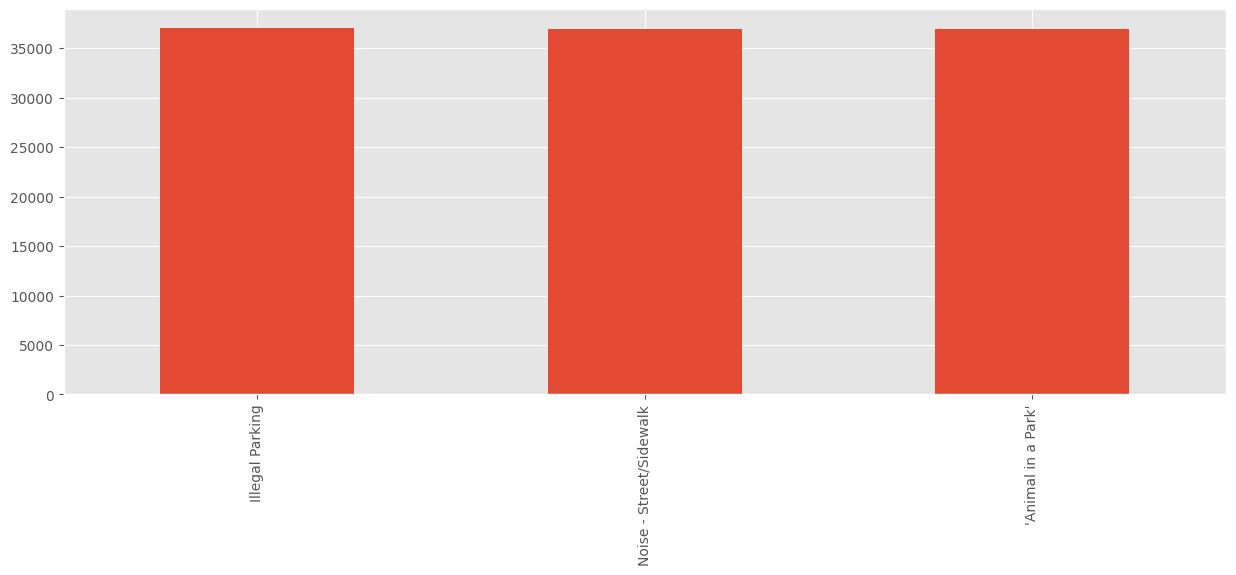

In [41]:
complaint_counts[:10].plot(kind='bar')

## Request real result

Now that we finished our analysis on the mock data, we can request this execution on the real data.

In [42]:
@sy.syft_function(input_policy=sy.ExactMatch(df=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(df):
    complaint_counts = df['Complaint Type'].value_counts()
    return complaint_counts[:10]

Request code execution

In [43]:
req = guest_domain_client.api.services.code.request_code_execution(get_counts)

In [44]:
submitted_code = guest_domain_client.code[0]

In [45]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [46]:
new_project = sy.Project(name="Pandas chapter 2",
                         description="Hi, I would like to plot the histogram of the complaint types.")

In [47]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [48]:
guest_domain_client.submit_project(new_project)

<class 'syft.service.response.SyftSuccess'>: Project Submitted

# Data owner: execute function

In [50]:
from syft.service.project.project import Project

In [51]:
domain_client = node.client.login(email="info@openmined.org", password="changethis")

# Get messages

In [52]:
messages = domain_client.api.services.messages.get_all_for_status(sy.MessageStatus.UNDELIVERED)

In [53]:
messages

,type,id,subject,status,created_at,linked_obj
0,syft.service.message.messages.Message,59f623ba8c384ea0bd35e57a343d99f5,Project Approval,MessageStatus.UNDELIVERED,2023-05-15 14:04:30,<<class 'syft.service.project.project.Project'...
1,syft.service.message.messages.Message,1145988ae1f945bb9ae85d53973547f9,Approval Request,MessageStatus.UNDELIVERED,2023-05-15 14:04:30,<<class 'syft.service.request.request.Request'...


In [54]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [55]:
request = project_message.link.requests[0]
func = request.changes[0].link
op = func.output_policy_type

In [56]:
func

```python
class UserCode:
  id: str = 63e16a381dcd466baf3adff5971292cc
  node_uid: str = 04bfe550af88494baa9bd45fe98bbe13
  user_verify_key: str = d2de1508547c9a998f8e83b61da2ff5ae2650ddbd9637638593e44a4e85b3020
  raw_code: str = "@sy.syft_function(input_policy=sy.ExactMatch(df=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(df):
    complaint_counts = df['Complaint Type'].value_counts()
    return complaint_counts[:10]
"
  input_policy_type: str = <class 'syft.service.policy.policy.ExactMatch'>
  input_policy_init_kwargs: str = {NodeView(node_name='pandas-test-domain-1', verify_key=50a6773dfa7e4c55c6c73b7a862758c9c86d5fdbd345c7da562189ac2f2fc3df): {'df': <UID: 401129f375344d7b9c220899e17670c8>}}
  input_policy_state: str = b''
  output_policy_type: str = <class 'syft.service.policy.policy.OutputPolicyExecuteOnce'>
  output_policy_init_kwargs: str = {}
  output_policy_state: str = b''
  parsed_code: str = "def user_func_get_counts_d2de1508547c9a998f8e83b61da2ff5ae2650ddbd9637638593e44a4e85b3020_ced68a4f95bc589adb5d44379eadb950ec506fd867517162b08636312d78c3f6(df):

    def get_counts(df):
        complaint_counts = df['Complaint Type'].value_counts()
        return complaint_counts[:10]
    result = get_counts(df=df)
    return result"
  service_func_name: str = "get_counts"
  unique_func_name: str = "user_func_get_counts_d2de1508547c9a998f8e83b61da2ff5ae2650ddbd9637638593e44a4e85b3020_ced68a4f95bc589adb5d44379eadb950ec506fd867517162b08636312d78c3f6"
  user_unique_func_name: str = "user_func_get_counts_d2de1508547c9a998f8e83b61da2ff5ae2650ddbd9637638593e44a4e85b3020"
  code_hash: str = "ced68a4f95bc589adb5d44379eadb950ec506fd867517162b08636312d78c3f6"
  signature: str = (df)
  status: str = {NodeView(node_name='pandas-test-domain-1', verify_key=50a6773dfa7e4c55c6c73b7a862758c9c86d5fdbd345c7da562189ac2f2fc3df): <UserCodeStatus.SUBMITTED: 'submitted'>}
  input_kwargs: str = ['df']
  enclave_metadata: str = None

```

In [57]:
get_counts_user_func = func.unsafe_function

In [58]:
real_data = domain_client.datasets[0].assets[0].data

In [59]:
real_result = get_counts_user_func(df=real_data)

In [60]:
real_result[:3]

HEATING                   14200
GENERAL CONSTRUCTION       7471
Street Light Condition     7117
Name: Complaint Type, dtype: int64

In [61]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [62]:
asset = guest_client.datasets[0].assets[0]

In [63]:
guest_client.api.services.code[0].status

{NodeView(node_name='pandas-test-domain-1', verify_key=50a6773dfa7e4c55c6c73b7a862758c9c86d5fdbd345c7da562189ac2f2fc3df): <UserCodeStatus.EXECUTE: 'execute'>}

```python
Pointer
```
<Axes: >

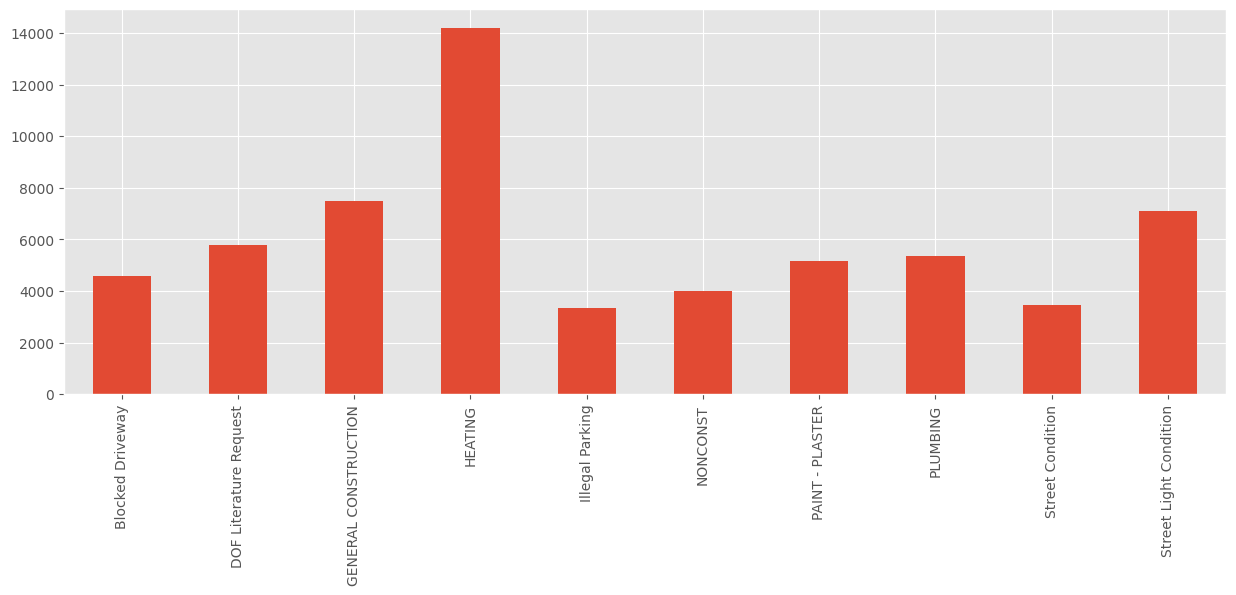

In [64]:
real_result = guest_client.api.services.code.get_counts(df=asset)
real_result.plot(kind="bar")

In [65]:
if node.node_type.value == "python":
    node.land()

Stopping pandas-test-domain-1
